# Predicting Heart Disease using ML

In this project we will be analyzing a dataset from a R&D company which provides cardiovascular information about patients. The data has been collected from multiple hospitals and anonymized for use, the dataset contains features such as Age, Sex, RestingECG, ST_slope and HeartDisease. Using some Machine lerning models we will aim to predict whether or not a new patient will have heart disease. This revelvant because many people suffer from heart disease because of a variety of factors.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
hd = pd.read_csv('heart_disease_prediction.csv')
# lets check out the number of observations and features in this dataset
print(f'features: {hd.shape[1]}\
        observations: {hd.shape[0]}')

features: 12        observations: 918


In [ ]:
print(hd.dtypes) # see all the data types for each feature to get sense of categorical and non-categorical data

print(f'Mean Age: {hd["Age"].mean()}') # the mean age of the normal pateint

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object
Mean Age: 53.510893246187365


We can see that the mean age of a patient is around 53 years, this is what we would expect because from mid to old age is when heart disease usually peaks.

In [ ]:
print(hd['Cholesterol'].min())
print(hd['RestingBP'].min())

0
0


We can see that RestingBP or resting blood pressure has minimum value of zero which is unlikely because that physically cannot be possible. Cholesterol is also a minimum value of zero, but can that be possible? The American Heart Association notes:

*''is a composite of different measurements. Your total blood cholesterol is calculated by adding your HDL and LDL cholesterol levels, plus 20% of your triglyceride level.''*

This information is enough to let us know that Cholesterol cannot be zero.

In [ ]:
hd.isnull().sum() # let's check for any missing data

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


Now I will graph the data from all the categorical features to get sense of demographics and statistics, but first let's gather all the categorical features under categorical_cols

In [ ]:
categorical_cols = hd.select_dtypes(include=['object']).columns.tolist()
categorical_cols.extend(['HeartDisease', 'FastingBS'])

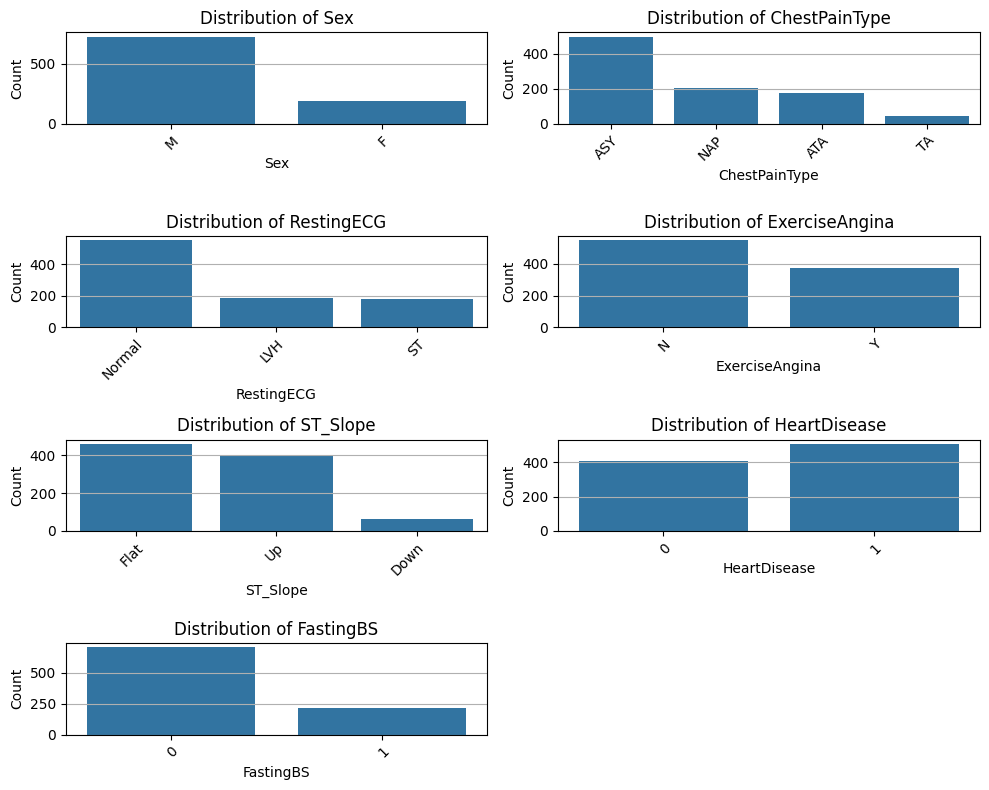

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8)) # Adjust figsize as needed
for i, col in enumerate(categorical_cols):
    row = i // 2  # Calculate subplot row index
    col_num = i % 2  # Calculate subplot column index
    ax = axes[row, col_num]  # Get the current subplot
    category_counts = hd[col].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.grid(axis='y')
fig.delaxes(axes[3, 1])
plt.tight_layout()
plt.show()

We can now see a wide range of demographics, interestingly males seem to have a much higher share of patients than females. Asymptotic chest pain type has a much higher occurence in heart disease than other chest pain type. A normal resting ECG has higher occurence in heart disease than other ECG type. People with no exercise angina seem to have higher chance of heart disease. A flat ST_slope shows a higher chance of heart disease than any other ST_slope type. Finally people with no fasting BS seem to have higher count than people with fasting BS. Now we will regroup all the data above but this time we will graph it by grouping it according to Heart Disease, where 0 is no and 1 is yes.

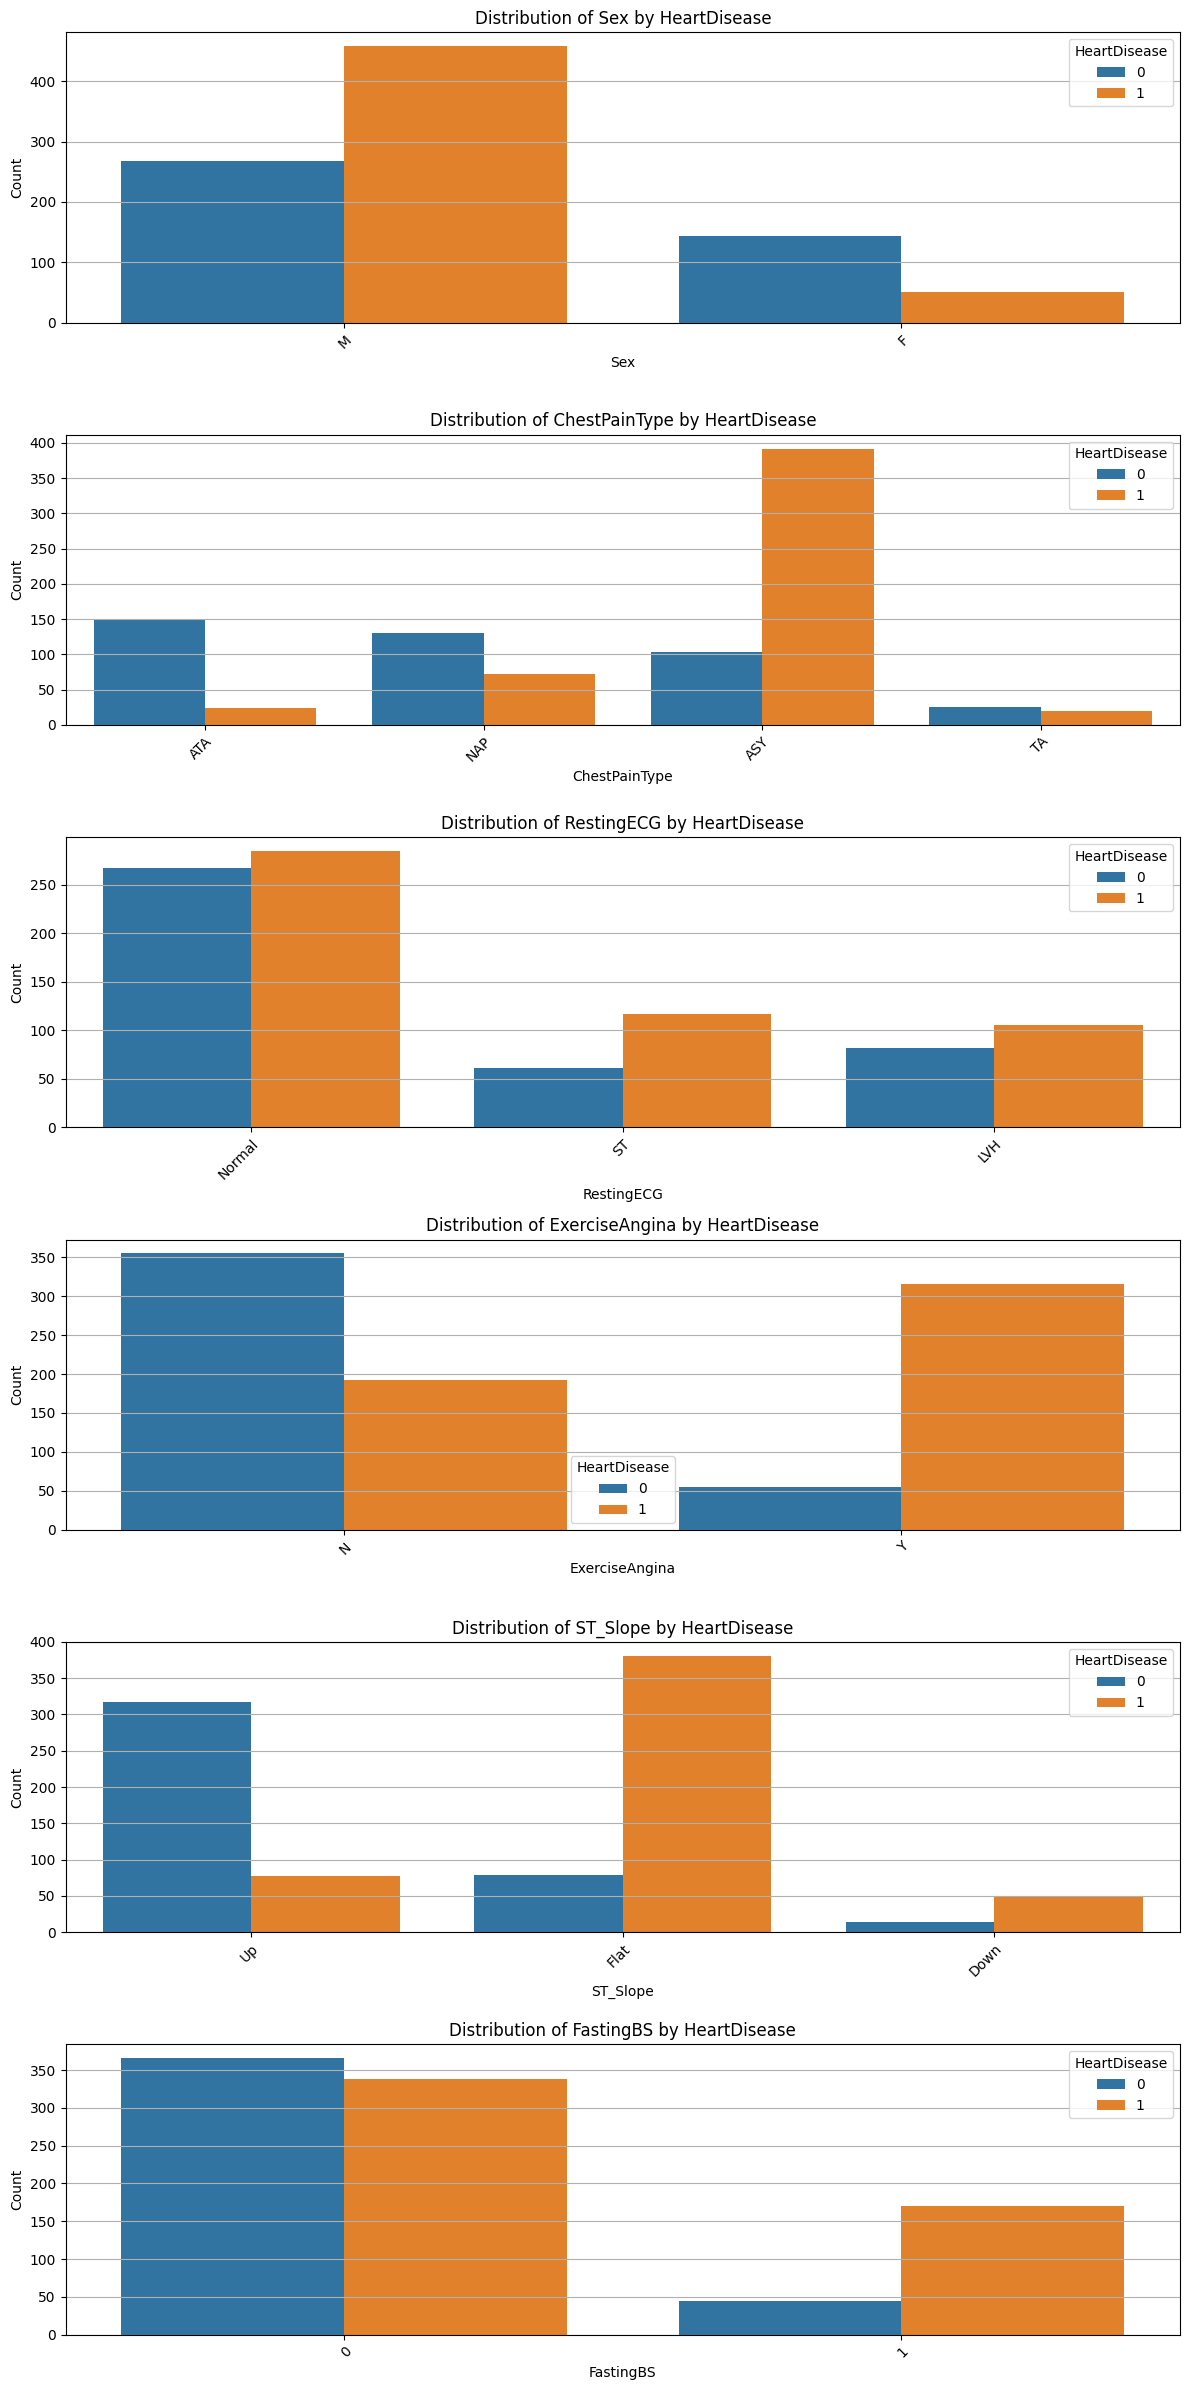

In [ ]:
categorical_cols = hd.select_dtypes(include=['object']).columns.tolist()
categorical_cols.extend(['FastingBS'])

fig, axes = plt.subplots(nrows=len(categorical_cols), ncols=1, figsize=(12, 4 * len(categorical_cols)))
for i, col in enumerate(categorical_cols):
    ax = axes[i]  # Get the current subplot
    sns.countplot(data=hd, x=col, hue='HeartDisease', ax=ax)  # or sns.barplot(...)
    ax.set_title(f'Distribution of {col} by HeartDisease')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.grid(axis='y')
plt.tight_layout()
plt.show()

Looking at the bar plots above we can make out some patters which will be benefical for our training model:

1. The distribtion for people having heart disease is much higher in ASY chest pain type than any other chest pain types.

Also, the rest of the observations we made above seem to be true here when it clearly displayed by the grouping the data according to heart disease type.

In [ ]:
restingbp_zero = hd[hd['RestingBP'] == 0].shape[0]
cholesterol_zero = hd[hd['Cholesterol'] == 0].shape[0]

print(f'RestingBP: {restingbp_zero}')
print(f'Cholesterol: {cholesterol_zero}')

RestingBP: 1
Cholesterol: 172


We can see that RestingBP has one row with value 0 and Cholesterol has 172 rows!
Lets clean the data and replace the zero values with the median for that column

In [ ]:
restingbp_median = hd['RestingBP'][hd['RestingBP'] > 0].median()
cholesterol_median = hd['Cholesterol'][hd['Cholesterol'] > 0].median()

hd['RestingBP'] = hd['RestingBP'].replace(0, restingbp_median)
hd['Cholesterol'] = hd['Cholesterol'].replace(0, cholesterol_median)

In [ ]:
# lets check again to be sure

restingbp_zero = hd[hd['RestingBP'] == 0].shape[0]
cholesterol_zero = hd[hd['Cholesterol'] == 0].shape[0]

print(f'RestingBP: {restingbp_zero}')
print(f'Cholesterol: {cholesterol_zero}')

RestingBP: 0
Cholesterol: 0


Before we begin training our machine on the data we have to select features for out model to base it's training on:

We can select the following features:

1. Age
2. Sex
3. ChestPainType
4. Cholesterol
5. FastingBS

Now let's convert our categorical columns into dummy varibales

In [ ]:
categorical_cols = hd.select_dtypes(include=['object']).columns.tolist()
categorical_cols.extend(['HeartDisease', 'FastingBS'])

hd = pd.get_dummies(hd, columns=categorical_cols, drop_first=True)

Now let's create a Pearson's correlation heat map using Sea Born's heat map () function. This will help us know which feature strongly influences or correaltes with the Heart Disease outcome, which will be our y variable.

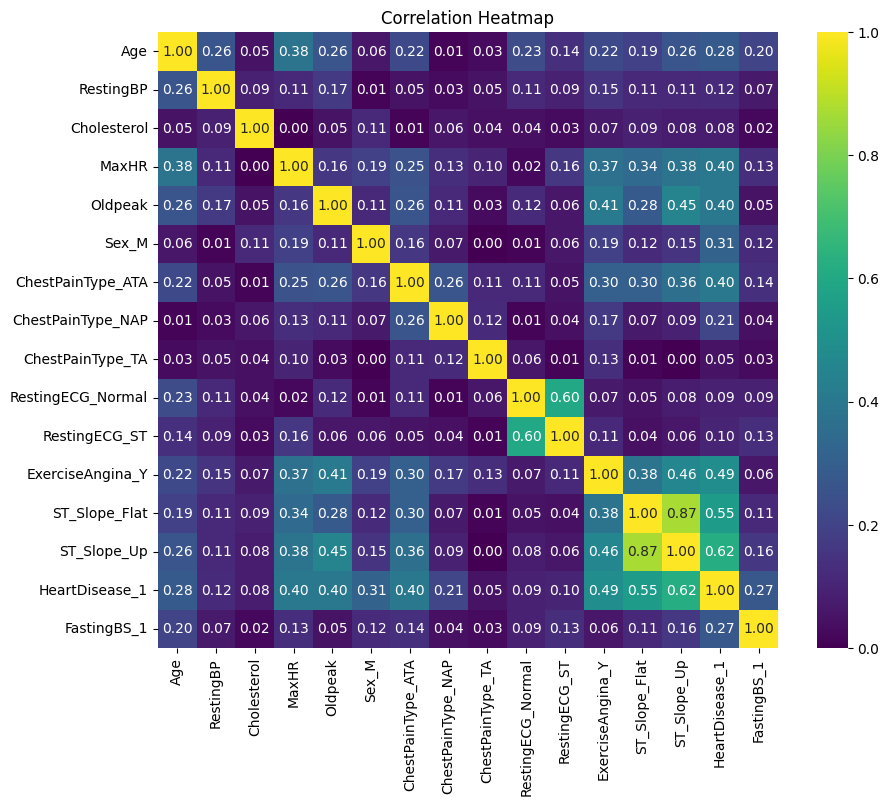

In [ ]:
corr_matrix = abs(hd.corr().round(2))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# lets filter out the correlations with HeartFisease greater than 0.3

heart_disease_corr = corr_matrix['HeartDisease_1'].sort_values(ascending=False)
high_corr_categories = heart_disease_corr[heart_disease_corr > 0.3]
print(high_corr_categories)

HeartDisease_1       1.00
ST_Slope_Up          0.62
ST_Slope_Flat        0.55
ExerciseAngina_Y     0.49
MaxHR                0.40
Oldpeak              0.40
ChestPainType_ATA    0.40
Sex_M                0.31
Name: HeartDisease_1, dtype: float64


We can see the following features correlate with heart disease the most:

1. ST_Slope_Up
2. ST_Slope_Flat
3. ExerciseAngina_Y
4. MaxHR
5. OldPeak
6. ChestPainType_ATA
7. Sex_M

Now we can begin our K-NN analysis on the data with these 7 features in mind. First we will split the data into a training and validation set.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train = hd.drop('HeartDisease_1', axis=1) # identify the x and y varibles
y_train = hd['HeartDisease_1']

features = ['ST_Slope_Up', 'ST_Slope_Flat', 'ExerciseAngina_Y', 'MaxHR', 'Oldpeak', 'ChestPainType_ATA', 'Sex_M'] # the 7 features we want to analyze our data on

test_size = [0.1,0.15,0.2,0.25,0.3] # let's test out different test sizes and k numbers to see which gives us the best result
n_neighbors = [2,3,4,5]

results = []

for test in test_size:
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test, random_state=42)
  for n_neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)
    for feature in features:
      knn.fit(X_train[[feature]], y_train)
      y_pred = knn.score(X_val[[feature]], y_val)
      y_pred = round(y_pred, 2)
      results.append((test, n_neighbor, feature, y_pred))

df = pd.DataFrame(results, columns=['test_size', 'n_neighbors', 'feature', 'accuracy'])
df = df.sort_values(by='accuracy', ascending=False)
df

,test_size,n_neighbors,feature,accuracy
49,0.15,5,ST_Slope_Up,0.87
42,0.15,4,ST_Slope_Up,0.87
35,0.15,3,ST_Slope_Up,0.87
28,0.15,2,ST_Slope_Up,0.87
119,0.30,3,ST_Slope_Up,0.86
...,...,...,...,...
27,0.10,5,Sex_M,0.41
117,0.30,2,ChestPainType_ATA,0.38
112,0.30,2,ST_Slope_Up,0.38
118,0.30,2,Sex_M,0.38


As we can see the best model performance was when test_size = 0.15, meaning 15% of the data was for testing. The best was with ST_Slope_UP and n_neighbors did not seem to matter much, this model got an accuracy of about 87% which is pretty good.

Next  we will try to train our model on all of the features, but before we do that we should scale the selected features in the range (0,1) to normalize it. This will ensure not all features get weighted equally in the calculation, so it gives us the most accurate result.

In [ ]:
features = ['ST_Slope_Up', 'ST_Slope_Flat', 'ExerciseAngina_Y', 'MaxHR', 'Oldpeak', 'ChestPainType_ATA', 'Sex_M']

X_train, X_val, y_train, y_val = train_test_split(X_train[features], y_train, test_size=0.15, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_scaled, y_train)
y_pred = knn.score(X_val_scaled, y_val)

print(f'Accuracy with n=4: {y_pred*100:.2f}%')

Accuracy with n=4: 77.78%


Surprising! we got a lower accuracy level with all the features, rather than if we based our model on only the ST_Slope_Up feature. Now we will experiment with more parameters also known as hyperparameter tuning with GridSearchCV. We will use the Scikit's GridSearchCV module which will be dictionary of parameters we will search for to get the best optimization for the K-NN algorithim.

In [ ]:
from sklearn.model_selection import GridSearchCV

X = hd.drop('HeartDisease_1', axis=1)
y = hd['HeartDisease_1']

test_sizes = [0.1,0.15,0.2,0.25,0.3]

results = []

for test in test_sizes:

  X_train, X_val, y_train, y_val = train_test_split(X[['ST_Slope_Up']], y, test_size=test, random_state=42)
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_val_scaled = scaler.transform(X_val)
  knn = KNeighborsClassifier()
  param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                'weights': ['uniform', 'distance'],
                'metric': ['manhattan', 'minkowski']} # the parameter grid or dictionary being used in K-NN algorithim
  grid_search = GridSearchCV(knn, param_grid, scoring='accuracy')
  grid_search.fit(X_train_scaled, y_train)

  best_params = grid_search.best_params_
  best_score = grid_search.best_score_

  results.append((test, best_params, best_score))

df = pd.DataFrame(results, columns=['test_size', 'best_params', 'best_score'])
df = df.sort_values(by='best_score', ascending=False)
df




,test_size,best_params,best_score
4,0.30,"{'metric': 'manhattan', 'n_neighbors': 4, 'wei...",0.819234
3,0.25,"{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.818238
2,0.20,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.817426
0,0.10,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.765396
1,0.15,"{'metric': 'manhattan', 'n_neighbors': 4, 'wei...",0.762821


Using the GridSearchCV parameters we can see that the best result gives us a  best score of 0.819~0.82 (82% accuracy) with a test size of about 0.3 or 30%, the best parameters of: manhattan metric, n_neighbors = 4, and uniform weights. We will use this to apply the method on our testing dataset.

In [ ]:
# evaluate the model on the test set
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X[['ST_Slope_Up']], y, test_size=0.30, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=4, weights='uniform', metric='manhattan')
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy with n=4: {accuracy*100:.2f}%')

Accuracy with n=4: 80.07%


Putting the model to the test for our test set we can see that with parameters k=4 (n_neighbors = 4), weights = uniform and the measuring metric being manhattan we get a accruacy of about 80%

# Concluding Thoughts...

Looking at the analysis we have done with the K-NN alorithim we can see that we got an accuracy of about 80.1% which is good but not great. This could be due to multiple factors which add in , to give us the outcome of whether or not a patient has heart disease. We used the ST_Slope_Up feature has our primary feature to determine if the patient will have heart diease. This is based on the multi-step tuning we did in the previous set of code. Had we chosen a diffirent feature, weight or metric we could have gotten a better or worst result. Perhaps changing the random state value could yield better results. We could also use a different algorithim entirely and see which one works better.

Nonetheless, I have done a little bit of extra coding below with different features and random state values which I chose randomly to see which gives us a better result.

In [ ]:
features = ['ST_Slope_Up', 'ST_Slope_Flat', 'ExerciseAngina_Y', 'MaxHR', 'Oldpeak', 'ChestPainType_ATA', 'Sex_M']

test_sizes = [0.1,0.15,0.2,0.25,0.3]
random_states = range(1,50)

results = []

for test in test_sizes:
  for random_state in random_states:
    for feature in features:
      X_train, X_test, y_train, y_test = train_test_split(X[[feature]], y, test_size=test, random_state=random_state)
      scaler = MinMaxScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      knn = KNeighborsClassifier()
      param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'weights': ['uniform', 'distance'],
                    'metric': ['manhattan', 'minkowski']}
      grid_search = GridSearchCV(knn, param_grid, scoring='accuracy')
      grid_search.fit(X_train_scaled, y_train)
      best_score = grid_search.best_score_
      best_params = grid_search.best_params_

      # now let's test this on the test set
      best_estimator = grid_search.best_estimator_
      y_pred = best_estimator.predict(X_test_scaled)
      accuracy = accuracy_score(y_test, y_pred)
      results.append((test, random_state, feature, best_params, best_score, accuracy))

df = pd.DataFrame(results, columns=['test_size', 'random_state', 'feature', 'best_params', 'best_score', 'accuracy'])
df = df.sort_values(by='accuracy', ascending=False)
df


,test_size,random_state,feature,best_params,best_score,accuracy
162,0.10,24,ST_Slope_Flat,"{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.760277,0.913043
161,0.10,24,ST_Slope_Up,"{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.803885,0.902174
0,0.10,1,ST_Slope_Up,"{'metric': 'manhattan', 'n_neighbors': 4, 'wei...",0.805104,0.891304
686,0.20,1,ST_Slope_Up,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.750732,0.885870
343,0.15,1,ST_Slope_Up,"{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",0.801282,0.884058
...,...,...,...,...,...,...
622,0.15,40,Sex_M,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",0.651282,0.326087
643,0.15,43,Sex_M,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.541026,0.326087
1682,0.30,45,ExerciseAngina_Y,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.683660,0.297101
233,0.10,34,ExerciseAngina_Y,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.727652,0.239130


# WOW!

Wow!, that execution took a whole 45 mins to complete but we ended up with a much better score. With all the various combinations and permutations we loaded in the code the best score we got was of 0.76 with a accuracy of 91%!, which is better score and way more accurate. With a test size of 0.1 or 10%, a random state of 24, manhattan metric, k=2, and uniform weight distribution we ended up 89% but this time with the ST_Slope_Flat feature. Below I graphed a feature vs. accuracy chart to visualize the accuracy. This gives us an idea of the data we are dealing with. Also, I would like to give an honourable mention to index 161, it came in at a close second with an accuracy reading of 90%, and a best score of 0.8. With a test_size of 0.1, random state of 24, manhanttan metric, and k=2 with uniform weights and ST_Slope_Up feature. One can argue index 161 is better reading than 162 since it has  better best score and measures based on ST_Slope_Up feature. Finally the violin plot below shows us the ST_Slope_Up feature gives us a more accurate reading.

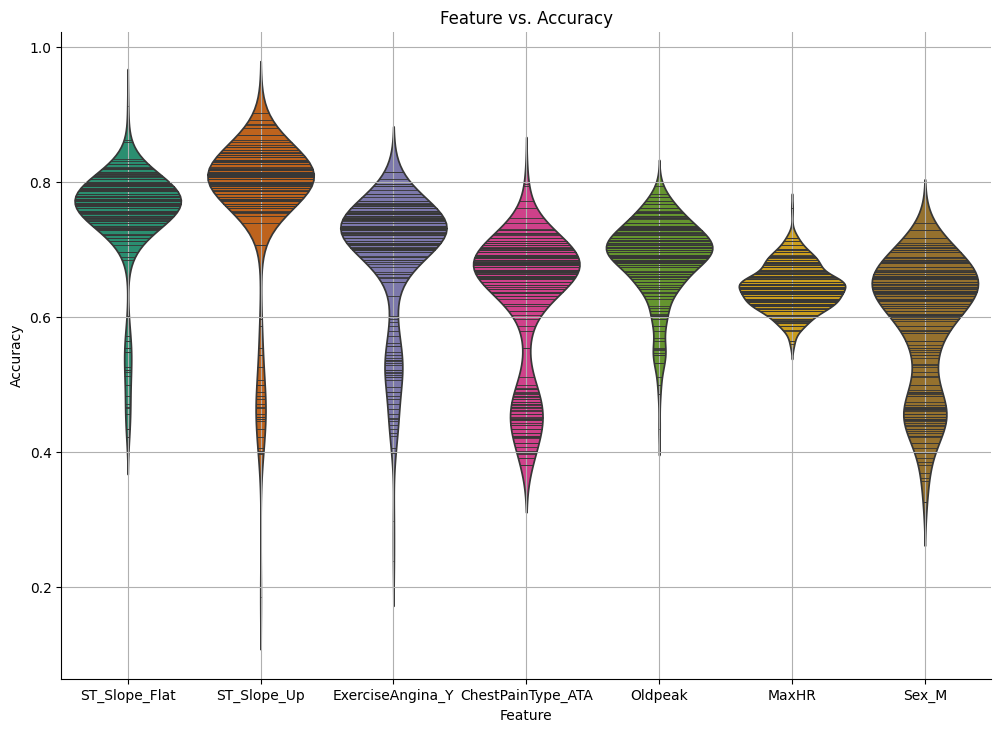

In [ ]:
figsize = (12, 1.2 * len(df['feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='feature', y='accuracy', inner='stick', palette='Dark2', hue='feature', legend=False)
plt.title('Feature vs. Accuracy')
plt.xlabel('Feature')
plt.ylabel('Accuracy')
sns.despine(top=True, right=True, bottom=False, left=False)
plt.grid()
plt.show()